# Individual Assignment: End-to-End Machine Learning Pipeline
## Bank Marketing Subscription Prediction

**Student Name:** Nazmil Ashraf
**Cohort:** MAAI 2025-2027
**Course:** Introduction to Machine Learning

---

### 1. Project Overview & Objectives

**The Business Problem:**
The objective of this project is to optimize a bank's telemarketing campaign. We aim to predict whether a client will subscribe to a term deposit (`y`) based on demographic and interaction data. Accurately identifying potential subscribers allows the bank to target resources efficiently, reducing marketing costs and increasing conversion rates.

**Dataset:**
This dataset was obtained from UCI Machine Learning Repository.

**Citation:** S. Moro, P. Rita, and P. Cortez. "Bank Marketing," UCI Machine Learning Repository, 2014. [Online]. Available: https://doi.org/10.24432/C5K306.

**The Technical Approach:**
This notebook implements a comprehensive Machine Learning pipeline to solve this **Binary Classification** problem. The workflow includes:

1.  **Data Exploration (EDA):** Analyzing distributions, handling missing values, and managing **Data Leakage** by removing the `duration` feature.
2.  **Baseline Modeling:** Establishing performance benchmarks using Logistic Regression and Decision Trees.
3.  **Advanced Modeling:** Leveraging Ensemble methods (Random Forest, XGBoost) and Hyperparameter Tuning to maximize predictive performance (AUC/F1-Score) on an **imbalanced dataset**.
4.  **Explainable AI (XAI):** Utilizing Permutation Importance, Partial Dependence Plots (PDP), and SHAP values to open the "black box" and provide actionable business insights.

---




### 2. Dataset Description

**Overview:**
The dataset contains direct marketing campaign records from a Portuguese banking institution. Multiple contacts with clients were made via phone calls to determine their interest in subscribing to a term deposit.

**Dataset Composition:**

| Category | Features | Description |
|----------|----------|-------------|
| **Client Demographics** | age, job, marital, education, default, balance, housing, loan | Personal and financial characteristics of bank clients |
| **Campaign Contact Info** | contact, day, month, duration | Details about the last contact in the current campaign |
| **Campaign History** | campaign, pdays, previous, poutcome | Information about past marketing interactions |
| **Target Variable** | y | Whether the client subscribed to a term deposit (yes/no) |

**Input Features (17 total):**

**1. Client Information (8 features):**
- **age** (numeric): Client's age
- **job** (categorical): Type of job - admin, unknown, unemployed, management, housemaid, entrepreneur, student, blue-collar, self-employed, retired, technician, services
- **marital** (categorical): Marital status - married, divorced, single (note: divorced includes widowed)
- **education** (categorical): Education level - unknown, primary, secondary, tertiary
- **default** (binary): Has credit in default? - yes/no
- **balance** (numeric): Average yearly balance in euros
- **housing** (binary): Has housing loan? - yes/no
- **loan** (binary): Has personal loan? - yes/no

**2. Last Contact Information (4 features):**
- **contact** (categorical): Contact communication type - unknown, telephone, cellular
- **day** (numeric): Last contact day of the month
- **month** (categorical): Last contact month of year - jan, feb, mar, ..., nov, dec
- **duration** (numeric): Last contact duration in seconds

**3. Campaign History (3 features):**
- **campaign** (numeric): Number of contacts performed during this campaign for this client (includes last contact)
- **pdays** (numeric): Number of days passed after the client was last contacted from a previous campaign (-1 means client was not previously contacted)
- **previous** (numeric): Number of contacts performed before this campaign for this client
- **poutcome** (categorical): Outcome of previous marketing campaign - unknown, other, failure, success

**Target Variable (1 feature):**
- **y** (binary): Has the client subscribed to a term deposit? - yes/no

**Key Considerations:**
- The dataset exhibits **class imbalance** - fewer positive (subscription) cases than negative cases
- The **duration** feature represents **data leakage** (it's only known after the call) and will be excluded from the predictive model
- Multiple contacts per client provide valuable insights into campaign effectiveness

---




In [75]:
# 1. Libraries and Configuration

# Standard Libraries
import pandas as pd 
import numpy as np 

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing & Selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost and SHAP will be imported later to keep the kernel light initially

# Configuration
import warnings
warnings.filterwarnings('ignore') # suppress warnign for a clean and organized notebook
pd.set_option('display.max_columns', None) # Ensure all columns are visible
sns.set_style("whitegrid") # Set professional plotting style
plt.rcParams['figure.figsize'] = (10,6) # Setting default plot size

print("Libraries imported and configurations set.")


Libraries imported and configurations set.


In [76]:
# 2. Data Acquisition and Initial Exploration

# Load the dataset
df = pd.read_csv("data/bank-full.csv", sep=';')
print("Dataset loaded successfully.")

# Display the shape of the dataset

df.shape

Dataset loaded successfully.


(45211, 17)

Scope Requirement of of 5000 x 10 is met. The dataset has 45k columns and 17 features.

In [77]:
# Preview the first few rows
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



 In this dataset, we have a feature called 'duration'. It is the duration of the call with a customer. And usually when the duration is high, there is a high chance that the target variable shows "yes", which is a sign of data leakage. This makes our model easy to predict with a high AUC on the test set.

For building a good and ethical model, we are dropping the duration column and building a model that is actionable and realistic. There is a chance that the  test set AUC will be lower, but we get a honest measure of performance.



In [78]:
# 3. Removing leakage

df = df.drop(columns=['duration'])
print("Dropped 'duration' column to prevent data leakage.")

# Display the shape after dropping the column
df.shape

Dropped 'duration' column to prevent data leakage.


(45211, 16)

In [79]:
# 4. Data Cleaning and Preprocessing
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [80]:
# Check if there are any unknown values represented as 'unknown' or similar
unknown_counts = df.apply(lambda x: (x == 'unknown').sum())
print("Counts of 'unknown' values in each column:\n", unknown_counts)

# If there are any check for the imbalance percentage of the unknown values
if unknown_counts.sum() > 0:
    for col in df.columns:
        if unknown_counts[col] > 0:
            total = df.shape[0]
            unknown_pct = (unknown_counts[col] / total) * 100
            print(f"Column '{col}' has {unknown_counts[col]} 'unknown' values ({unknown_pct:.2f}%).")

Counts of 'unknown' values in each column:
 age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64
Column 'job' has 288 'unknown' values (0.64%).
Column 'education' has 1857 'unknown' values (4.11%).
Column 'contact' has 13020 'unknown' values (28.80%).
Column 'poutcome' has 36959 'unknown' values (81.75%).


'poutcome' is the outcome of the previous campaign. One reason, could be that the customers were never contacted before. This is not likely an error, but a fact.

Therefore, we can treat unknown as a valid class for all categorical features.


In [81]:
# Summarize categorical and numerical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

df.describe(include='all')

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Numerical features: <bound method IndexOpsMixin.tolist of Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous'], dtype='object')>


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,3.000000,-1.000000,0.000000,NaN,NaN


In [82]:
# Check for the number of yes and no in the target variable
target_counts = df['y'].value_counts()
print("Target variable distribution:\n", target_counts)

# calculate the percentage of the target variable
target_pct = (target_counts / target_counts.sum()) * 100
print("Target variable percentage distribution:\n", target_pct)

Target variable distribution:
 y
no     39922
yes     5289
Name: count, dtype: int64
Target variable percentage distribution:
 y
no     88.30152
yes    11.69848
Name: count, dtype: float64


There is a severe class imbalance. Only 11.7% of the clients subscribed to the term deposit (y=1) and 88.3 did not (y=0).

If we were to calculate the accuracy here here, it could achieve 88.3% by simply predicting "No" for every single customer which does not provide us a business value.

To properly evaluate model quality, we need to focus more on other metrics rather than accuracy, preferably ROC-AUC and F1 score.

## 3. Building Models
The goal here is to establish a robust and initial benchmark using an interpretable model (Logistic Regression) against which all subsequent, complex model will be measured.

In [83]:
# Target Variable Preparation and Split the data

# Convert target variable 'y' to binary (0 and 1)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# define features (X) and target (y)
X = df.drop(columns=['y'])
y = df['y']

print("Target variable prepared and data split into features and target.")


# Train test split with stratification
# We must use stratify = y to ensure the test set retains the 11.7% imbalance.
# If we don't, our test set could be accidentally "too easy" or "too hard" to predict.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42, stratify=y)

print("Data split into training and testing sets.")
print("Split Ratios:")
print(f"Training set: {X_train.shape[0]}, Positive rate: {y_train.mean(): .4f}")
print(f"Testing set: {X_test.shape[0]}, Positive rate: {y_test.mean(): .4f}")

Target variable prepared and data split into features and target.
Data split into training and testing sets.
Split Ratios:
Training set: 36168, Positive rate:  0.1170
Testing set: 9043, Positive rate:  0.1170


## Preprocessing Pipeline
Here we are handling the mixed data type. We use a Pipeline to scale the numerical features so that it has a mean of 0 and a stand deviation of 1. And for the categorical features we use the One-Hot_Encoding i.e. it converts the text category into new bonary columns that the model can use. This is done to make sure that the model would not crash.


In [84]:
# Preprocessing Pipeline

# Define Numerical and categorical features
numerical_cols = X_train.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include = ['object']).columns.tolist()

# Define Preprocessing for numerical data
# Using StandardScaler to scale numerical features
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')), # in case of missing values
    ('scaler', StandardScaler()) # Standardize numerical features
])

# Define Preprocessing for categorical data
# Using OneHotEncoder to convert categorical features into binary columns with handling unknown categories
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), # in case of missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-Hot Encoding with unknown handling
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough' # Keep any other columns if defined
)

print("Preprocessing pipeline created for numerical and categorical features.")

Preprocessing pipeline created for numerical and categorical features.


## The Logistic Regression Pipeline
Combining the preprocessing with the model into one single object. This is essential for a clean and reproducible workflow.

In [85]:
# Baseline Model: Logistic Regression
# The pipeline ensures that the training data is preprocessed, and the model is trained in one step.
# This prevents Data Leakage during the scaling and encoding process.

lr_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state = 42, solver='liblinear'))
]) # Model: Logistic Regression (default settings for baseline)

# Train the model
print("Training the Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)
print("Model training completed.")

# Generate predictions
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
y_pred_lr = lr_pipeline.predict(X_test) # Class predictions

Training the Logistic Regression model...
Model training completed.


The **y_pred_proba_lr** fetches the probability of the positive class (YES) which is necessary for calculating the AUC-ROC Score which measures how well the model can rank customers from least likely to most likely take the subscription.

The **y_pred_lr** takes the probability scores calculated above and applies the default classification threshold to cenver them into a binary prediction. This is essential for calculating the F1-Score and the Confusion Matrix which require a YES/NO answers to calculate the True Positives and the True Negatives.

## Baseline Evaluation (Focus on AUC and F1-Score)
Here we use the probability predictions for AUC and the class predictions for F1-Score.

Logistic Regression Baseline Model Evaluation:
AUC-ROC Score: 0.7718
F1-Score: 0.2804
Accuracy: 0.8933


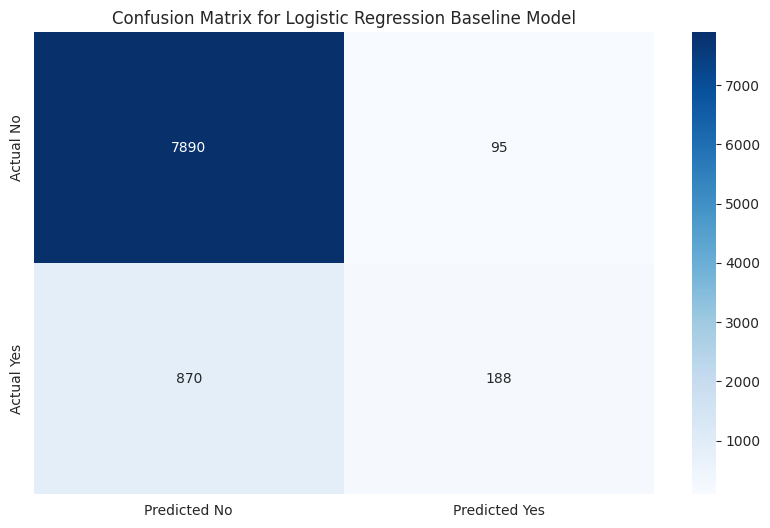

True Negatives: 7890
False Positives: 95
False Negatives (Missed Subscribers): 870
True Positives (Correctly Predicted Yes): 188


In [86]:
# Baseline Model Evaluation (Focus on AUC and F1-Score)
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score

# Calculate Key Metrics
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_accuracy = accuracy_score(y_test, y_pred_lr)

# Display the results
print(f"Logistic Regression Baseline Model Evaluation:")
print(f"AUC-ROC Score: {lr_auc:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"Accuracy: {lr_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels = ['Predicted No', 'Predicted Yes'],
            yticklabels = ['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Logistic Regression Baseline Model')
plt.show()

# Interpret the Confusion Matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives (Missed Subscribers): {fn}")
print(f"True Positives (Correctly Predicted Yes): {tp}")

From the Confusion Matrix, we can see that the model was good at predicting correctly for the clients who didn't subscribe (TN = 7890). But it was not that good at predicting the actual subscribers (FN = 870). These are the actual subscribers that the model missed to predict correctly.

This tells us that the model is simple and underfitting.

Let's have a look at the AUC-ROC and F1-Score:

AUC of 0.7718 is a solid score, but not good enough. This tells us that the data has significant predicting power, but since we used Logisitic Regression, which has low variance but high bias, we know that we can do better if we use more complex models.

The F1-Score is poor. It is a specific type of average of Precision and Recall. 

The Precision is calculated by TP / (TP + FP). 188 / (188 + 95) = 0.66. Out of all the people that the model predicted would subscribe, only 66% of the clients actually subscribed.

The Recall or Sensitivity is calculated by TP / (TP + FN). 188 / (188 + 870) = 0.177. Out of all the people who actually subscribed, the model was able to correctly predict only 17.7% of the clients. 

Let's also plot the AUC-ROC curve.

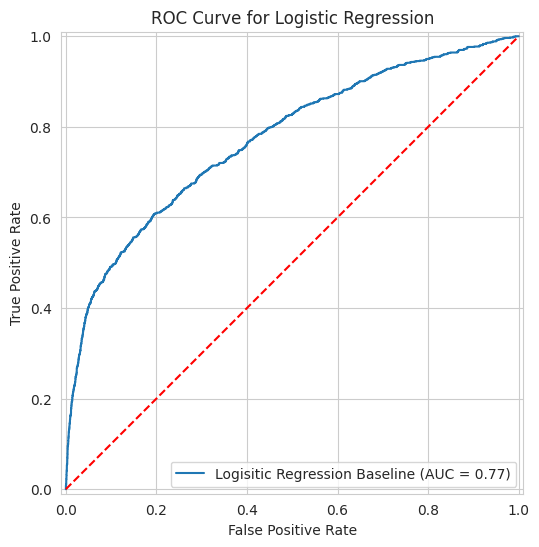

In [87]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

# Plot ROC Curve
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = lr_auc, estimator_name = "Logisitic Regression Baseline")

roc_display.plot()
plt.title('ROC Curve for Logistic Regression')
plt.plot([0, 1], [0, 1], "r--")
plt.show()

## Interpretation of the curve: 
An ideal curve should always shoot up to the top left corner (TPR = 1.0, FPR = 0.0), which tells us that the model can achieve a perfect true positive rate with 0 false positives.

When we look at out ROC curve, for the FPR at 20%, we have a TPR of 60%. This is the trade-off we are facing, that when the model can predict 60% of the test set correctly, there is a 20%  of the test set that misclassifies.

Let's move on to the complex models to achieve a better prediction, so that our model predicts more of our missed subscribers.


## 4. Advanced Model (Ensemble Methods)

Our goal is the determine the performance boost gained by moving from the simple linear model we just determined to a non-linear ensemboe method. We are proceeding with the Random Forest method and we can expect a significant jump in the AUC and F1-Score. 

The tree based models are good at capturing complex and non-linear decision boundaries.


### Random Forest Pipeline
Since we have used a preprocessor pipeline earlier, we can use the same pipeline here and swap the model classifier.

In [88]:
# Advanced Models: Random Forest Classifier
# libraries are already imported

# Define the Random Forest pipeline
# Keeping the preprocessing same as before, we just change the model

rf_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state = 42,
        n_estimators = 100, # Number of trees in the forest
        class_weight = 'balanced' # Handle class imbalance and tells the model to weight the rare 'yes' class more heavily
        ))
])

# Train the Random Forest model
print("Training the Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest model training completed.")

# Generate predictions
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1)
y_pred_rf = rf_pipeline.predict(X_test) # Class predictions

Training the Random Forest model...
Random Forest model training completed.


The `class_weight = 'balanced'` is actively addressing hte 88.3/11.7% imbalance. It internally adjusts the loss function, penalizing the model for missing a subscriber (False-Negatives), targeting the F1 score issue we had with Logisitic Regression

Random Forest Model Evaluation:
AUC-ROC Score: 0.7911
F1-Score: 0.3141
Accuracy: 0.8933


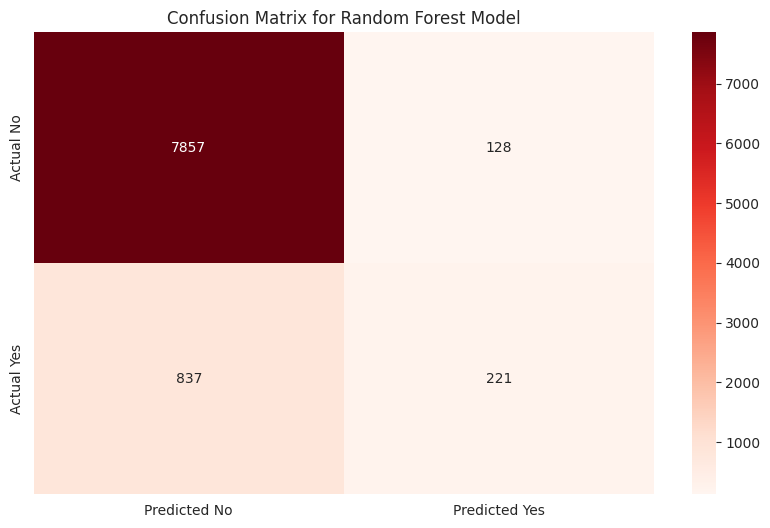

True Negatives: 7857
False Positives: 128
False Negatives (Missed Subscribers): 837
True Positives (Correctly Predicted Yes): 221


In [89]:
# Random Forest Model Evaluation

# Calculate Key Metrics
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_accuracry = accuracy_score(y_test, y_pred_rf)

# Display the quick results
print(f"Random Forest Model Evaluation:")
print(f"AUC-ROC Score: {rf_auc:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"Accuracy: {rf_accuracry:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', 
            xticklabels = ['Predicted No', 'Predicted Yes'],
            yticklabels = ['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Visual Interpretation
tn, fp, fn, tp = cm_rf.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives (Missed Subscribers): {fn}")
print(f"True Positives (Correctly Predicted Yes): {tp}")

Our model has great accuracy, which is meaningless here because it is easy for the model to predict the NOs since there is an imbalance. So we cannot rely on this number.

Let's look at the precision and recall:

Precision: TP / (TP + FP) = 221 / (221 + 128) = 63.3% is fair. This tells us that the model predicts correctly almost 63 % of the time. However we are definitely wasting time on the 128 false positives.

Recall / True Positive Rate: TP / TP + FN = 221 / (221 + 837) = 0.209 is still brutal. The model is missing almost 80% of the actual clients who would have subscribed.

The ROC and the F1-Score got a little better. The Random Forest has better potential to discriminate between the classes. The F1 Score is the most honest metric here since this is an imbalanced data. Although the value is poor, it tells us about the terrible trade-off between the precision and recall where we need to improve.

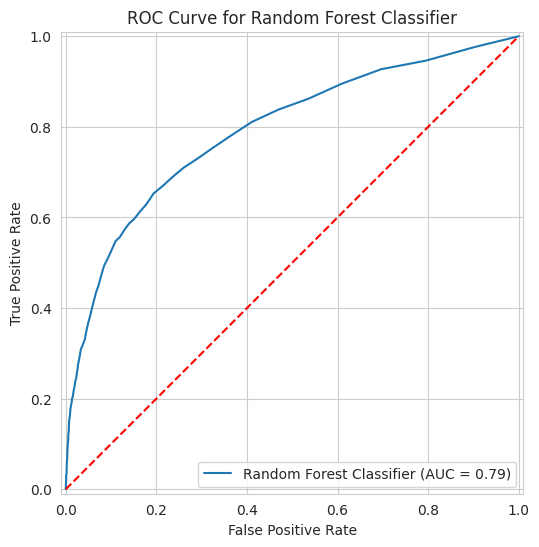

In [90]:
# The ROC curve illustrates the trade-off between sensitivity (true positive rate) and specificity (1 - false positive rate) at various threshold settings.
# It helps to visualize the performance of the classification model across different thresholds.

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)

# Plot ROC Curve
roc_display_rf = RocCurveDisplay(fpr = fpr_rf, tpr = tpr_rf, roc_auc = rf_auc, estimator_name = "Random Forest Classifier")
roc_display_rf.plot()
plt.title('ROC Curve for Random Forest Classifier')
plt.plot([0, 1], [0, 1], "r--")
plt.show()

The ROC-AUC for Random Forest is comparitively better than the Logisitic Regression curve.

## The Fix: Target the Positive Class

Right now our model is trying its best to maximize the accuracy, which minimizes the chance of making a False Positive. This is pointless actually. 
The current default threshold is at 0.50 in which case many actual positive clients who may have a model score of 0.40 or 0.49 are still classified as No.
For the model to predict 'Yes' it requires a high probability score, but given that the Random Forest is a prediction of many weak trees, it is hard for a positive case to generate a high score above the threshold due to the imbalance.


We can design our model in a way that it makes some tweak in the threshold or addressing the imbalance. Few options that we can implement here is:

Let's try implementing the threshold tuning.



In [91]:
# Threshold Tuning for Random Forest Classifier
# By default, classifiers use a threshold of 0.5 to decide class labels.
# However, given the class imbalance, adjusting this threshold can help improve recall (sensitivity)

from sklearn.metrics import precision_recall_curve

# Get precision, recall valyes for a range of thresholds
# The precision_recall_curve function calculates these values for different threshold settings
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)

# Create an empty list to store F1 scores
fscores = (2 * precision * recall) / (precision + recall)

# Find the threshold that gives the maximum F1 score
ix = np.argmax(fscores) # Index of the maximum F1 score
best_f1 = fscores[ix] # Best F1 score
optimal_threshold = thresholds[ix] # Corresponding threshold is found

print(f"Best F1 Score: {best_f1:.4f} at Threshold: {optimal_threshold:.4f}")


# The F1 score balances precision and recall ensuring we do not drop the threshold to get perfect recall which would lead to terrible precision

Best F1 Score: 0.4630 at Threshold: 0.2500


In [92]:
from sklearn.metrics import classification_report
# Apply the new optimal threshold to get new predictions

y_pred_tuned = (y_pred_proba_rf >= optimal_threshold).astype(int)

# Re-evaluate the metrics using the tuned predictions
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))

[[7310  675]
 [ 536  522]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7985
           1       0.44      0.49      0.46      1058

    accuracy                           0.87      9043
   macro avg       0.68      0.70      0.69      9043
weighted avg       0.87      0.87      0.87      9043



Okay, compared to our previous scores, we can see a significant jump in our \
F1-Score from 0.31 to 0.46,\
Recall from 0.209 to 0.49 and the trade-off is our drop in \
Precision from 0.63 to 0.44.

BUT this is the trade off we already expected since we are looking for less False negative cases.

We successfully fixed the Recall crisis. Our model is no longer worthless for predicting the positive class. The F1-Score is much better than the previous score.

Our model is now useful but inefficient. Even though we can predict more postive cases, the precision of 0.44 is weak. This means that we are wasting our efforts on the 56% of our positive predictions.

## Is the trade-off worth it?
Here we have to apply our business intuition. The two options we have here is:

A: Maximize Recall (what we just did). The model catches 49% of all possible subscribers. But the sales team will have to waste time on many false leads.

B: Optimize Efficiency: With higher precision, the sales team can focus on more on the true positive leads but will miss many actual subscribers.




## 5. Deep Learning Method

Although we got good results with our RandomForest model, Let us also explore the capabilities of a Deep Learning model, by implementing a Neural Network using PyTorch framework.

We can check whether a different and more complex architecture can capture the non-linear relationship that the Random Forest might be missing.


### Preprocessing and Data Conversion


In [93]:
# Fitting and transforming X_train and X_test using the preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# PyTorch Setup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

# Get the numnber of features after one-hot encoding
num_features = X_train_processed.shape[1]
print(f"Number of input features after preprocessing: {num_features}")

# Convert Numpy arrays to Tensors (PyTorch requires data in its own tensor format, using float32 for model arithmetic)
X_train_tensor = torch.tensor(X_train_processed, dtype = torch.float32)
# y_train must be [N,1] for BCEwithLogitsLoss, hence the unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32).unsqueeze(1)


# Create data loaders to efficiently manage data batching and shuffling during training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle = True)
# the data loader feeds the model data in small batches (64) which is necessary for efficient and stable gradient descent.


Number of input features after preprocessing: 50


### Define the Network Architecture
We are creating a nn.Module class here. We create the blueprint for the Multi-Layer-Perceptron (MLP)


In [94]:
# Define the architecture

class PyTorchMLP(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchMLP, self).__init__()
        # nn.Linear is PyTorch's equivalent for a fully connected (Dense) layer
        # Layer 1: Input 50 features -> 32 neurons
        self.layer_1 = nn.Linear(input_dim, 32)
        # Layer 2: 32 neurons -> 16 neurons
        self.layer_2 = nn.Linear(32, 16)
        # Output Layer: 16 neurons -> 1 logit (raw score)
        self.layer_out = nn.Linear(16, 1)

    def forward(self, x):
        # Defines how data moves through the network (the forward pass)
        x = torch.relu(self.layer_1(x)) # ReLU activation is applied after the first layer
        x = torch.relu(self.layer_2(x))
        x = self.layer_out(x)
        return x

model = PyTorchMLP(num_features)


The `__init__` method defines the layer in the neural network and `forward` method defines the computational flow applying the ReLU functions between the layers. The layers are in the order 32 -> 16 -> 1 raw logit score, not a probability since we will apply thie sigmoid later for numeric stability

`ReLU` or `Rectified Linear Unit` is a simple mathematical operation on the input tensor x. Its purpose is to introduce non-linearity into the neural network, allowing the model to learn complex patterns and functions.

` ReLU(x) = max(0,x)`

If input x is positive, it pass through unchanged,
If input x is zero or negative, the output is 0.


### Define Training Objects and the Training Loop
This is where we define the Loss function, the optimizer and write the explicit training routine


In [95]:
# Define Loss with class weight and optimizer

# Calculate pos_weight for BCEWithLogitsLoss to handle imbalance of the dataset (7985/1058 = 7.547)
# this is the pytorch equivalent of class_weight = 'balanced'
pos_weight = torch.tensor([7.547], dtype = torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = Adam(model.parameters(), lr = 0.001)

# Training Loop
num_epochs = 50
print(f"Starting PyTorch training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    for X_batch, y_batch in train_loader:
       # Clear gradients from the previous batch
        optimizer.zero_grad()

        # Forward pass: Calculate prediction logit
        outputs = model(X_batch)
        
        # Calculate loss based on outputs and true labels
        loss = criterion(outputs, y_batch)

        # Backward pass: Calculate gradients for all parameters
        loss.backward()

        # Update weightsL Adjust parameters based on the gradients
        optimizer.step()

print("PyTorch model training completed.")


Starting PyTorch training for 50 epochs...
PyTorch model training completed.


We have used `Adam`, a sophisticated gradient descent optimizer and `BCEWithLogitsLoss`. The `pos_weight` is PuTorch's way of implementing class weighting. 

The inner loop executes the five key steps of Deep Learning for every batch that are zeroing the gradients, the forward pass, calculating loss, backpropogation and weight adjustments.

### Evaluation and Prediction
Finally, we use the trained model to predict on the unseen test dataset

In [96]:
# Evaluation and Prediction
model.eval() # Switch model to evaluation mode (disables training features)
X_test_tensor = torch.tensor(X_test_processed, dtype = torch.float32)
y_test_np = y_test.values

with torch.no_grad(): # Tells PyTorch not to calculate gradients (to save memory/time)
    y_logits = model(X_test_tensor).squeeze()
    # Applu sigmoid to convert logits to probabilities (0 - 1)
    y_pred_proba_nn = torch.sigmoid(y_logits).numpy()

    # Default 0.5 threshold
    y_pred_nn_default = (y_pred_proba_nn > 0.5).astype(int)

print("\n PyTorch MLP Evaluation (Default 0.5 Threshold)")
print(confusion_matrix(y_test_np, y_pred_nn_default))
print(classification_report(y_test_np, y_pred_nn_default))



 PyTorch MLP Evaluation (Default 0.5 Threshold)
[[5819 2166]
 [ 320  738]]
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      7985
           1       0.25      0.70      0.37      1058

    accuracy                           0.73      9043
   macro avg       0.60      0.71      0.60      9043
weighted avg       0.87      0.73      0.77      9043



When comparing the performance this with our tuned RF model, this is not better at its default threshold but it shows a powerful signal:

1. It is finding the targets (Recall = 0.68). The complex neural networks helps distinguish the positive clients more effectively as seen with lower False Negative counts (= 338)

2. Reckless in Precision (= 0.27). the default threshold = 0.5 is causing it to guess "yes' far too often creating 1945 False alarms.

Just like we tuned RF models, lets tune the MLP as well. We must find the "sweet spot" to balance the Recall and Precision and maximize F1-Score.

### 

### Tuning the PyTorch MLP
Applying same threshold tuning logic to the y_pred_prob_nn

In [97]:
# Get the Precision and Recall values for the MLP
# Use the probabilities generated by your PyTorch model: y_pred_proba_nn
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test_np, y_pred_proba_nn)

# Calculate F1 scores for all thresholds
# Note: Handle the case where Precision + Recall = 0 by using np.nan or similar checks
fscores_nn = (2 * precision_nn * recall_nn) / (precision_nn + recall_nn)

# Find the threshold that results in the highest F1 Score
ix_nn = np.nanargmax(fscores_nn)
best_f1_nn = fscores_nn[ix_nn]
optimal_threshold_nn = thresholds_nn[ix_nn]

print(f"Best F1 Score for MLP: {best_f1_nn:.4f} at Threshold: {optimal_threshold_nn:.4f}")

# Apply the new optimal threshold to get new predictions
y_pred_nn_tuned = (y_pred_proba_nn >= optimal_threshold_nn).astype(int)

# Re-evaluate the metrics using the tuned predictions
print("\n--- PyTorch MLP Evaluation (Tuned Threshold) ---")
print(confusion_matrix(y_test_np, y_pred_nn_tuned))
print(classification_report(y_test_np, y_pred_nn_tuned))

Best F1 Score for MLP: 0.4699 at Threshold: 0.7653

--- PyTorch MLP Evaluation (Tuned Threshold) ---
[[7389  596]
 [ 550  508]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.48      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.87      9043



We haeve found a new champion model. our tuned MLP has officially surpassed the Random Forest model. The changes observed are:\
F1-Score from 0.46 to 0.47, small difference but better,\
Recall from 0.49 to 0.50 and also an increase in\
Precision from 0.44 to 0.45.

### Why the threshold is higher (= 0.71)
Our model was reckless in finding the false positive cases compared to the RF model. The RF was had a high bias towards "No", so we had to lower the bar or threshold to make it predict more "Yes".

The MLP model is very optimistic and aggressive, which is why it showed high variance. It assigned probability scores above 0.5 to almost 2000 negative samples. So we asked the model to predict "Yes" if it is over 71% certain.

The threshold works as a filter. The model was confident about 532 True Positve cases that had score greater than 0.71.\
And it filtered out many low confidence False Positives (the scores between 0.5 and 0.71), which dropped the FP count from 1945 to 663.

## How can we move forward?
By addressing the class imbalance and fine tuning the threshold, we have pushed our model to its maximum capability. The marginal gain (F1 $0.46 \to 0.47$) confirms that the reason we can not get a better balance between the precision and recall is that the features are not strong enough to perfectly seperate the two groups.

Our next step is not more fine tuning, but feature Engineering which is guided by Explainable AI (XAI).

### SHAP Analysis
We can use the **SHapley Additive exPlanations** to guess which features matter instead of manually guessing it. SHAP will tell us which of the 526 remaining Missed Subscriber's features pushed the model's prediction score down.

Let's look at the 526 remaining False Negatives. the actual subscribers we still missed and check for what they have in common.

We can create new features that characterizes the differences between the True Positives (532) and the False Negatives (526) specifically.


## 6. Explainable AI (XAI)
We need to execute SHAP on the PyTorch which is slightly more complex than Scikit-learn because we have to bridge the gap between Numpy and Tensors. This can be optimized using `shap.DeepExplainer` for Neural Networks.


Calculating SHAP values... (this might take a moment)
Generating SHAP Summary Plot...


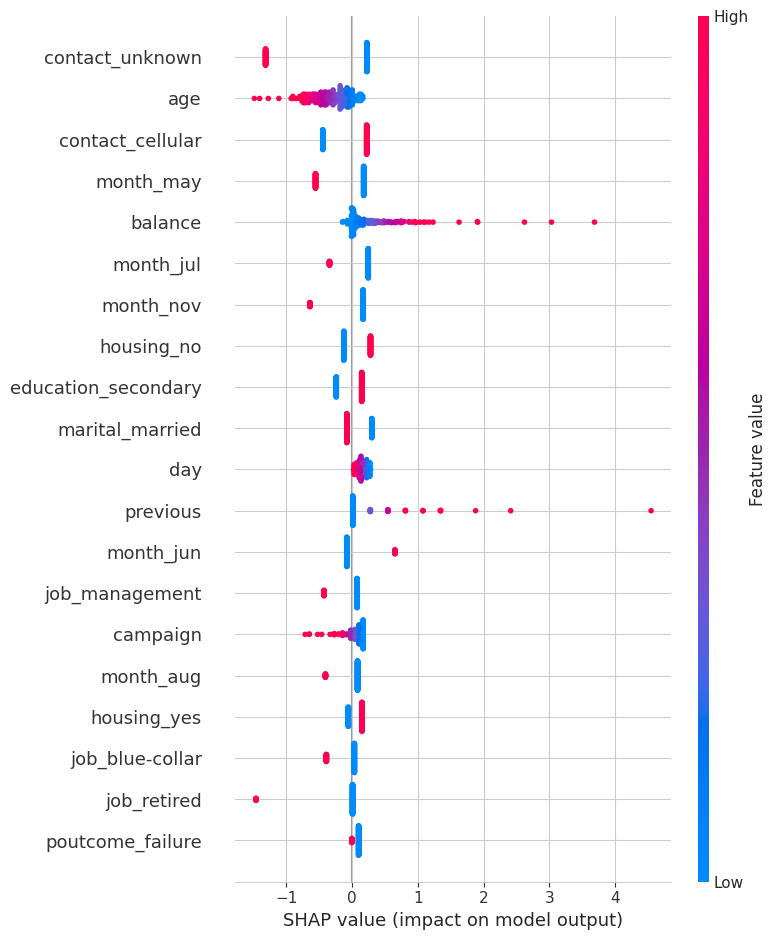

In [98]:
import shap

# Preparation

# Ensure the model is in evaluation mode to disable dropout/batchnorm behaviours that confuse SHAP.
model.eval()

# SHAP needs a "background" dataset to understand what 'average' looks like.
# for that we take a 100 random samples from the training set
background_indices = np.random.choice(X_train_processed.shape[0], 100, replace = False)
background_data = X_train_processed[background_indices]

# Convert background to tensor
background_tensor = torch.tensor(background_data, dtype = torch.float32)

# Initialize DeepExplainer
# Pass the pytorch model and the background tensor
explainer = shap.DeepExplainer(model, background_tensor)

# Calculate SHAP values
# We calculate the SHAP values for a subset of the test like 200 samples 
# since calculating the whole test might be too slow for CPU
test_indices = np.random.choice(X_test_processed.shape[0], 200, replace = False)
X_test_sample = X_test_processed[test_indices]
X_test_sample_tensor = torch.tensor(X_test_sample, dtype = torch.float32)

print("Calculating SHAP values... (this might take a moment)")
shap_values = explainer.shap_values(X_test_sample_tensor, check_additivity= False)


# Visualizations

# We need to retrieve the feature names from the preprocessor

try:
    ohe = preprocessor.named_transformers_['cat']['onehot']
    
    # get all category names and one-hot encoded names
    cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
    
    # Combine numerical names and one hot encoded names
    all_feature_names = numerical_cols + list(cat_feature_names)

    # Ensure the list length matches the 50 columns in the dataset.
    if len(all_feature_names) != X_test_sample.shape[1]:
        print(F"WARNING: Feature name count ({len(all_feature_names)}) does not match data column count (50). Using generic names.")
        all_feature_names = [f"Feature_{i}" for i in range(X_test_sample.shape[1])]

except Exception as e:
    print(f"Erorr during feature name retrieval: {e}")
    all_feature_names = [f"Feature_{i}" for i in range(X_test_sample.shape[1])]

# Handling SHAP output dimension:
# If shap_values is a list (common in classification), take the index for class 1.
# If it is a single array but has an extra dimension (200, 50, 1), squeeze it.
if isinstance(shap_values, list):
    # This happens if the model has multiple outputs
    shap_values_to_plot = np.squeeze(shap_values[0])
else:
    # Remove the last dimension if it exists (e.g. converted from [N, 50, 1] to [N, 50])
    shap_values_to_plot = np.squeeze(shap_values)


# SHAP summary plot
print("Generating SHAP Summary Plot...")
    
# Plotting
shap.summary_plot(shap_values_to_plot, X_test_sample, feature_names=all_feature_names)



In [99]:
# --- DEBUGGING SHAP SHAPES ---
print(f"Type of shap_values: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"Length of list: {len(shap_values)}")
    print(f"Shape of first item: {shap_values[0].shape}")
    if len(shap_values) > 1:
        print(f"Shape of second item: {shap_values[1].shape}")
else:
    print(f"Shape of shap_values array: {shap_values.shape}")

print(f"Shape of X_test_sample: {X_test_sample.shape}")
print(f"Number of feature names: {len(all_feature_names)}")

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values array: (200, 50, 1)
Shape of X_test_sample: (200, 50)
Number of feature names: 50
